# Functions to be used for the task

Purpose of this notebook is to create functions that will be used later. These are sequential functions.

In [1]:
import pandas as pd
import folium

df = pd.read_csv('bike_rent/202101-divvy-tripdata.csv')
df = df.sample(1000)

In [2]:
# DataFrame -> DataFrame

# 1. filter and prepare data
#     - remove NA
#     - remove long durations 
#     - leave only from known station to station
#     - calculate the actual duration (time end - time start)

def filter_and_prepare_data(df):
    # Remove rows with NA in start_station_id or end_station_id
    df = df.dropna(subset=['start_station_id', 'end_station_id']).reset_index(drop=True)
    
    # Convert the 'started_at' and 'ended_at' columns to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    
    # Calculate duration in seconds
    df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()
    
    # Filter by duration, keeping trips from 1 minute to 1 hour
    df = df[(df['duration'] >= 60) & (df['duration'] <= 3600)].reset_index(drop=True)
    
    return df

print(f"Initial number of rows: {len(df)}")
df = filter_and_prepare_data(df)
print(f"Number of rows after filtering: {len(df)}")

Initial number of rows: 1000
Number of rows after filtering: 835


In [3]:
# DataFrame -> dict

# 2. check stats
#     - distribution per type, membership
#     - count each day total trips

def get_stats(df):
    bike_counts = df.rideable_type.value_counts().to_dict()
    member_counts = df.member_casual.value_counts().to_dict()
    daily_counts = df['started_at'].dt.date.value_counts().sort_index().to_dict()

    stats = {
        'bike_counts': bike_counts,
        'member_counts': member_counts,
        'daily_counts': daily_counts
    }

    return stats

def join_stats(stats):
    """
    Join multiple stats dictionaries into one.
    """
    joined_stats = {
        'bike_counts': {},
        'member_counts': {},
        'daily_counts': {}
    }

    for stat in stats:
        for key in joined_stats.keys():
            for k, v in stat[key].items():
                if k in joined_stats[key]:
                    joined_stats[key][k] += v
                else:
                    joined_stats[key][k] = v

    return joined_stats

    
# test join stats
stat1 = get_stats(df.sample(10))
stat2 = get_stats(df.sample(10))
joined_stat = join_stats([stat1, stat2])

In [24]:
all_stats = get_stats(df)

In [4]:
# DataFrame, station_dict -> station_dict

# 3. preprocess stations:
#     - for each station, find the center
#     - create a dict with station_id as key and (lat, lon) as value

def get_station_coordinates(df, station_coords):

    # Extract start and end station coordinates to one DataFrame
    start_coords = df[['start_station_id', 'start_lat', 'start_lng']]
    end_coords = df[['end_station_id', 'end_lat', 'end_lng']]
    start_coords = start_coords.rename(columns={
        'start_station_id': 'station_id',
        'start_lat': 'latitude',
        'start_lng': 'longitude'
    })
    end_coords = end_coords.rename(columns={
        'end_station_id': 'station_id',
        'end_lat': 'latitude',
        'end_lng': 'longitude'
    })
    all_coords = pd.concat([start_coords, end_coords])

    # Remove existing stations from the DataFrame
    all_coords = all_coords[~ all_coords.station_id.isin(station_coords.keys())]
    
    # Calculate the median coordinates for each station
    all_coords = all_coords.groupby('station_id').median().reset_index()
    new_station_coords = all_coords.set_index('station_id').T.to_dict('list')
    
    # Update then dict and return
    return station_coords | new_station_coords

station_coords = {}
station_coords = get_station_coordinates(df.sample(100), station_coords)
print(len(station_coords))
station_coords = get_station_coordinates(df, station_coords)
print(len(station_coords))

147
395


In [5]:
# 4. calculate the shortest routes' durations
#     - go through all trips
#     - save the duration (from start_id, to end_id), reuse it (lookup table)
#     - append the shortest durations

import networkx as nx
import osmnx as ox

MEAN_LAT = 41.90234770710154
MEAN_LNG = -87.64440345010253


def load_graph():
    # Create a graph from the center of the data
    G = ox.graph_from_point((MEAN_LAT, MEAN_LNG), dist=5000, network_type="bike")

    # Optionally, save and then load the graph
    # ox.save_graphml(G, "my_graph.graphml")
    # G = ox.load_graphml("my_graph.graphml")

    # assign speeds constant speed to all edges
    nx.set_edge_attributes(G, values=10, name="speed_kph")

    # convert length+speed → seconds
    G = ox.add_edge_travel_times(G)

    return G

G = load_graph()


In [8]:
def calculate_fastest_travel_time(G, start_lat, start_lng, end_lat, end_lng):
    # In the graph, get the nodes closest to the points
    origin_node = ox.nearest_nodes(G, Y=start_lat, X=start_lng)
    destination_node = ox.nearest_nodes(G, Y=end_lat, X=end_lng)

    # compute travel time in seconds
    try:
        travel_time_in_seconds = nx.shortest_path_length(G, origin_node, destination_node, weight='travel_time')
    except nx.NetworkXNoPath:
        print(f"No path found from ({start_lat}, {start_lng}) to ({end_lat}, {end_lng})")
        return -1
    
    return travel_time_in_seconds


# for the sake of an example
test = df.iloc[0]
start_lat = test.start_lat
start_lng = test.start_lng
end_lat = test.end_lat
end_lng = test.end_lng

print(f"Fastest travel time from ({start_lat}, {start_lng}) to ({end_lat}, {end_lng}): "
        f"{calculate_fastest_travel_time(G, start_lat, start_lng, end_lat, end_lng)} seconds")

Fastest travel time from (41.895501, -87.682017) to (41.871262, -87.673688): 1179.236831503033 seconds


In [31]:
from tqdm.notebook import tqdm


distance_cache = {} # (start_id, end_id) -> duration
station_coords = station_coords # (station_id -> (lat, lon))

def calculate_durations(df, G, station_coords):
    tbar = tqdm(total=len(df), desc="Calculating durations", unit="trip")
    durations = []
    for index, row in df.iterrows():
        tbar.update(1)
        start_id = row['start_station_id']
        end_id = row['end_station_id']
        
        # Check if the duration is already cached
        if (start_id, end_id) in distance_cache:
            duration = distance_cache[(start_id, end_id)]
        else:
            start_lat, start_lng = station_coords[start_id]
            end_lat, end_lng = station_coords[end_id]
            
            # Calculate the travel time
            duration = calculate_fastest_travel_time(G, start_lat, start_lng, end_lat, end_lng)
            
            # Cache the result
            distance_cache[(start_id, end_id)] = duration
        
        durations.append(duration)
    return durations

In [ ]:
durations = calculate_durations(df, G, station_coords)

<Axes: >

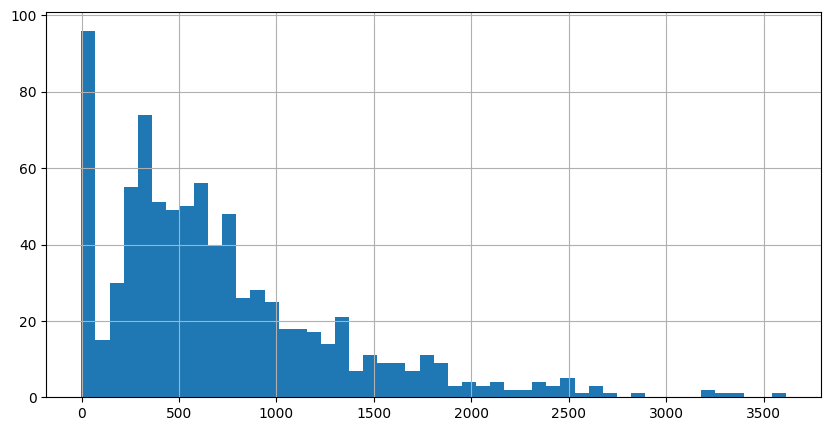

In [15]:
df["fastest_duration"] = durations
df["fastest_duration"].hist(bins=50, figsize=(10, 5))

In [17]:
len(df)

835

In [19]:
# 5. filter 
#     - remove routes which took much longer than the shortest possible duration (20% longer)

def filter_slow_riders(df, threshold=1.1):
    """
    Filter out trips where the actual duration is more than `threshold` times the fastest duration.
    This automatically drops -1 durations as well.
    """
    df = df[df['duration'] <= df['fastest_duration'] * threshold].reset_index(drop=True)
    return df

df = filter_slow_riders(df)
print(f"Number of rows after filtering slow riders: {len(df)}")

Number of rows after filtering slow riders: 559


In [20]:
# 6. check stats
#     - distribution per type, membership
#     - count each day total trips
#     - compare to original stats

fast_stats = get_stats(df)

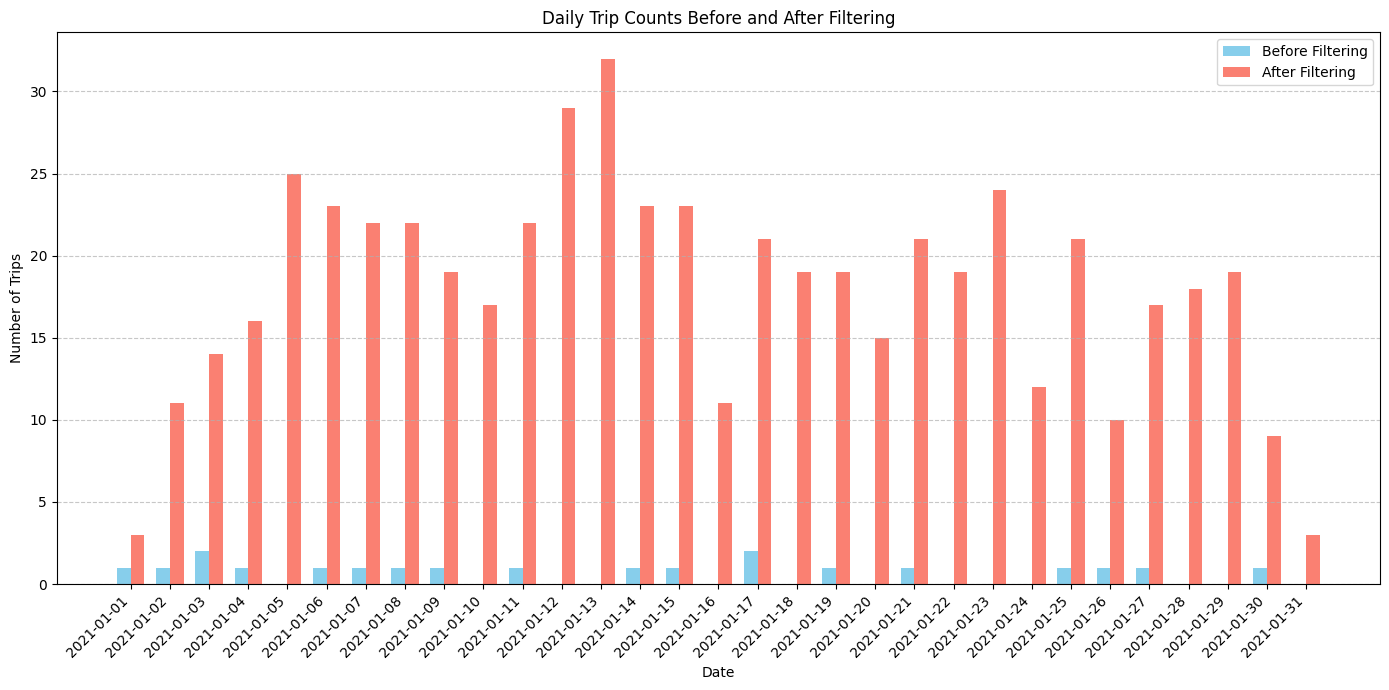

In [28]:
import matplotlib.pyplot as plt

# Convert dates to datetime objects for proper sorting
dates_all = list(all_stats['daily_counts'].keys())
counts_all = list(all_stats['daily_counts'].values())

dates_fast = list(fast_stats['daily_counts'].keys())
counts_fast = list(fast_stats['daily_counts'].values())

# Create a dictionary to map dates to their counts for both datasets
all_counts_dict = all_stats['daily_counts']
fast_counts_dict = fast_stats['daily_counts']

# Get the union of all dates
all_dates = sorted(set(dates_all + dates_fast))

# For each date, get the count from both datasets (0 if not present)
all_counts = [all_counts_dict.get(date, 0) for date in all_dates]
fast_counts = [fast_counts_dict.get(date, 0) for date in all_dates]

# Plot both datasets on the same figure
plt.figure(figsize=(14, 7))
width = 0.35  # Width of bars
x = range(len(all_dates))  # X positions for bars

plt.bar([i - width/2 for i in x], all_counts, width, label='Before Filtering', color='skyblue')
plt.bar([i + width/2 for i in x], fast_counts, width, label='After Filtering', color='salmon')

# Format x-axis with dates
plt.xticks(x, [date.strftime('%Y-%m-%d') for date in all_dates], rotation=45, ha='right')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Daily Trip Counts Before and After Filtering')
plt.legend()

# Adjust layout for better display
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# 7. plot the routes
#     - group by start and end station
#     - the more frequent the route is, the bigger the line

# Test all at once

In [33]:
import os

data_dir = 'bike_rent'
files = os.listdir(data_dir)

all_stats = []
fast_stats = []
distance_cache = {} # (start_id, end_id) -> duration
station_coords = {} # (station_id -> (lat, lon))

print("Loading graph...")
G = load_graph()
print("Graph loaded.")

Loading graph...
Graph loaded.


In [35]:

for file in tqdm(files):
    # read
    df = pd.read_csv(f'{data_dir}/{file}')
    df = df.sample(100)
    
    # filter
    print(f"Initial number of rows: {len(df)}")
    df = filter_and_prepare_data(df)
    print(f"Number of rows after filtering: {len(df)}")
    
    # get stats
    current_stats = get_stats(df)
    all_stats.append(current_stats)

    # get station coordinates
    station_coords = get_station_coordinates(df, station_coords)

    # calculate durations
    durations = calculate_durations(df, G, station_coords)
    df["fastest_duration"] = durations

    # filter slow riders
    df = filter_slow_riders(df)

    # get fast stats
    current_fast_stats = get_stats(df)
    fast_stats.append(current_fast_stats)

  0%|          | 0/12 [00:00<?, ?it/s]

Initial number of rows: 100
Number of rows after filtering: 81


Calculating durations:   0%|          | 0/81 [00:00<?, ?trip/s]

Initial number of rows: 100
Number of rows after filtering: 78


Calculating durations:   0%|          | 0/78 [00:00<?, ?trip/s]

No path found from (41.87811603010527, -87.63983845710754) to (41.87295, -87.66913)
Initial number of rows: 100
Number of rows after filtering: 82


Calculating durations:   0%|          | 0/82 [00:00<?, ?trip/s]

No path found from (41.886875, -87.62603) to (41.89766, -87.62351)
Initial number of rows: 100
Number of rows after filtering: 84


Calculating durations:   0%|          | 0/84 [00:00<?, ?trip/s]

No path found from (41.884241, -87.629634) to (41.870769, -87.625734)
Initial number of rows: 100
Number of rows after filtering: 79


Calculating durations:   0%|          | 0/79 [00:00<?, ?trip/s]

No path found from (41.890173, -87.626185) to (41.89766, -87.62351)
Initial number of rows: 100
Number of rows after filtering: 86


Calculating durations:   0%|          | 0/86 [00:00<?, ?trip/s]

No path found from (41.911722, -87.626804) to (41.89257, -87.614492)
No path found from (41.884241, -87.629634) to (41.890844, -87.6317825)
No path found from (41.884241, -87.629634) to (41.909668, -87.648128)
No path found from (41.911722, -87.626804) to (41.89766, -87.62351)
Initial number of rows: 100
Number of rows after filtering: 77


Calculating durations:   0%|          | 0/77 [00:00<?, ?trip/s]

No path found from (41.8777525, -87.634799) to (41.89766, -87.62351)
No path found from (41.884241, -87.629634) to (41.8793563587, -87.6297910363)
Initial number of rows: 100
Number of rows after filtering: 80


Calculating durations:   0%|          | 0/80 [00:00<?, ?trip/s]

No path found from (41.8742225, -87.62766883333333) to (41.89766, -87.62351)
No path found from (41.88602082773, -87.6308760584) to (41.89257, -87.614492)
No path found from (41.867491, -87.63219) to (41.89257, -87.614492)
Initial number of rows: 100
Number of rows after filtering: 83


Calculating durations:   0%|          | 0/83 [00:00<?, ?trip/s]

No path found from (41.867227, -87.625961) to (41.89257, -87.614492)
Initial number of rows: 100
Number of rows after filtering: 71


Calculating durations:   0%|          | 0/71 [00:00<?, ?trip/s]

No path found from (41.856268, -87.613348) to (41.89257, -87.614492)
No path found from (41.885637, -87.641823) to (41.89766, -87.62351)
Initial number of rows: 100
Number of rows after filtering: 70


Calculating durations:   0%|          | 0/70 [00:00<?, ?trip/s]

Initial number of rows: 100
Number of rows after filtering: 64


Calculating durations:   0%|          | 0/64 [00:00<?, ?trip/s]

No path found from (41.87811603010527, -87.63983845710754) to (41.884241, -87.629634)


In [36]:
all_ride_stats = join_stats(all_stats)
fast_ride_stats = join_stats(fast_stats)

# Create a table of bike types and their counts.
# One column for each type, one row for all rides / fast rides
bike_types = list(all_ride_stats['bike_counts'].keys())
bike_counts = {
    'All Rides': [all_ride_stats['bike_counts'].get(bike_type, 0) for bike_type in bike_types],
    'Fast Rides': [fast_ride_stats['bike_counts'].get(bike_type, 0) for bike_type in bike_types]
}
bike_counts_df = pd.DataFrame(bike_counts, index=bike_types)
bike_counts_df

,All Rides,Fast Rides
classic_bike,675,432
electric_bike,221,170
docked_bike,39,16


In [88]:
date_count_df = pd.DataFrame(
    all_ride_stats["daily_counts"].items(),
    columns=["date", "all_rides"]
)
date_count_df_fast = pd.DataFrame(
    fast_ride_stats["daily_counts"].items(),
    columns=["date", "fast_rides"]
)
# Merge the two DataFrames on the 'date' column
date_count_df = pd.merge(date_count_df, date_count_df_fast, on='date', how='outer')

# Aggregate per mont date_count_df
date_count_df['date'] = pd.to_datetime(date_count_df['date'])
date_count_df['month'] = date_count_df['date'].dt.to_period('M')
date_count_month_df = date_count_df.groupby('month')[["all_rides", "fast_rides"]].sum().astype(int)

date_count_month_df["percentage_fast"] = ((
    date_count_month_df["fast_rides"] / date_count_month_df["all_rides"]
) * 100).astype(int)

# Aggregate per day of the week
date_count_df['day_of_week'] = date_count_df['date'].dt.day_name()
date_count_weekday_df = date_count_df.groupby('day_of_week')[["all_rides", "fast_rides"]].sum()
# Sort the days of the week
date_count_weekday_df = date_count_weekday_df.T[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].T.astype(int)

date_count_weekday_df["percentage_fast"] = ((
    date_count_weekday_df["fast_rides"] / date_count_weekday_df["all_rides"]
) * 100).astype(int)